# Generation of bliss heatmaps for BRAF<sup>V600E</sup> melanoma cells

This script generates bliss heatmaps describing the regieon of synergistic drug interactions of RAF (belvarafenib) and MEK inhibitors (cobimetinib) for simulated BRAF<sup>V600E</sup> cells. Values are given relative to NRAS<sup>Q61</sup> simulated cells (with CRAF feedback) for comparison.

## Import of libraries
Importing libraries necessary to generate bliss heatmaps.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from synergy.combination import Bliss
import numpy as np
import os
from pathlib import Path
plt.rcParams.update({'font.size': 15})
#import synergy package 
from synergy.combination import Bliss

Changes to main file directory. This works provided the "main_dir" has the correct directory name and the cwd starts within the main file directory. This might require tweaking under some high performance computing setups.

In [2]:
main_dir = "MARM2_Andrew_8_24"
for i in Path().resolve().parents:
    if i.parts[-1] == main_dir:
        os.chdir(i)

## Generate bliss heatmaps

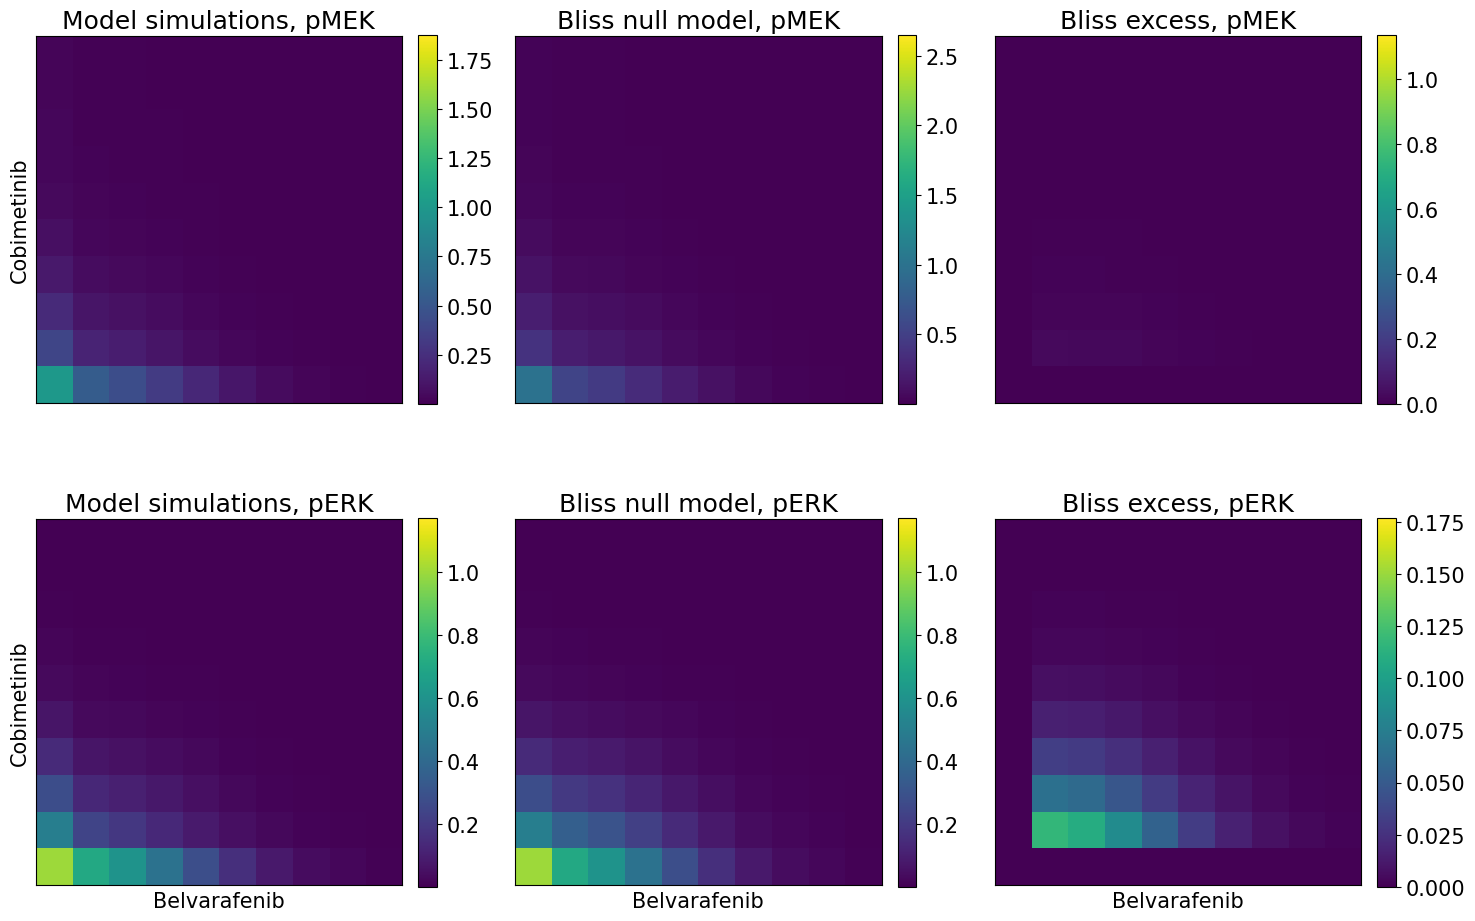

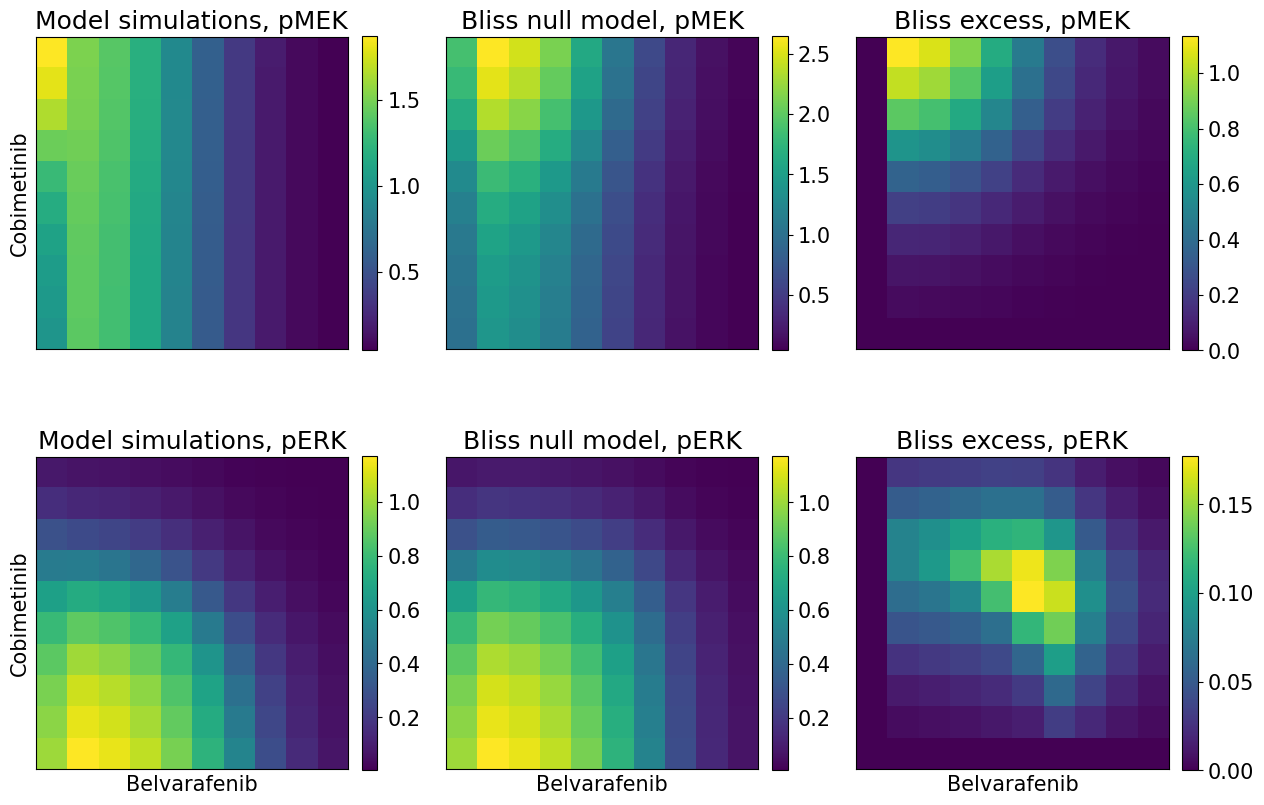

In [3]:
# Loads dataframes
dr_df_w_BRAF = pd.read_csv(Path("data/Steady_state_dose_responses/Belva_Cobi_SS_BRAF_V600E"))
dr_df_w_CRAF = pd.read_csv(Path("data/Steady_state_dose_responses/Belva_Cobi_SS_NRAS_Q61_w_CRAF_feedback"))
params = list(dr_df_w_BRAF.columns)[2:]
params = ['pMEK', 'pERK']

# extract drugless condition
zero_dose_w_BRAF_df = dr_df_w_BRAF.iloc[0]
zero_dose_w_CRAF_df = dr_df_w_CRAF.iloc[0]


#compare synergies among set of cooperative parameters
fig_w_BRAF, ax_w_BRAF = plt.subplots(len(params), 3,figsize=(15,10))
fig_w_CRAF, ax_w_CRAF = plt.subplots(len(params), 3,figsize=(15,10))
plt_titles=['Model simulations', 'Bliss null model',  'Bliss excess'];

for i in range(len(params)):
    #create and fit the Bliss models
    bliss_w_BRAF = Bliss()
    bliss_w_CRAF = Bliss()
    D1_w_CRAF=dr_df_w_CRAF["RAFi_0_uM"].to_numpy();
    D2_w_CRAF=dr_df_w_CRAF["MEKi_0_uM"].to_numpy(); 
    E_sim_n_CRAF=dr_df_w_CRAF[params[i]].to_numpy();
    
    D1_w_BRAF=dr_df_w_BRAF["RAFi_0_uM"].to_numpy();
    D2_w_BRAF=dr_df_w_BRAF["MEKi_0_uM"].to_numpy(); 
    E_sim_w_BRAF=dr_df_w_BRAF[params[i]].to_numpy();
    
    bliss_w_CRAF.fit(D1_w_CRAF,D2_w_CRAF, dr_df_w_CRAF[params[i]]/zero_dose_w_CRAF_df[params[i]]);
    bliss_w_BRAF.fit(D1_w_BRAF,D2_w_BRAF, dr_df_w_BRAF[params[i]]/zero_dose_w_BRAF_df[params[i]]);
    
    #reshape E_sim to matrix
    dr_df_mat_w_BRAF = dr_df_w_BRAF.set_index(["RAFi_0_uM","MEKi_0_uM"])
    matrix_w_BRAF = dr_df_mat_w_BRAF[[params[i]]].pivot_table(index = "RAFi_0_uM",columns = "MEKi_0_uM",values = params[i]).to_numpy()
    matrix_w_BRAF = matrix_w_BRAF/zero_dose_w_BRAF_df[params[i]]
    
    dr_df_mat_w_CRAF = dr_df_w_CRAF.set_index(["RAFi_0_uM","MEKi_0_uM"])
    matrix_w_CRAF = dr_df_mat_w_CRAF[[params[i]]].pivot_table(index = "RAFi_0_uM",columns = "MEKi_0_uM",values = params[i]).to_numpy()
    matrix_w_CRAF = matrix_w_CRAF/zero_dose_w_CRAF_df[params[i]]
    
    #extract bliss reference and bliss excess
    E_mat_bliss_ref_w_BRAF=np.rot90(bliss_w_BRAF.reference.reshape(np.shape(matrix_w_BRAF)));
    E_mat_bliss_syn_w_BRAF=np.rot90(bliss_w_BRAF.synergy.reshape(np.shape(matrix_w_BRAF)));
    matrix_w_BRAF = np.rot90(matrix_w_BRAF)
    
    E_mat_bliss_ref_w_CRAF=np.rot90(bliss_w_CRAF.reference.reshape(np.shape(matrix_w_CRAF)));
    E_mat_bliss_syn_w_CRAF=np.rot90(bliss_w_CRAF.synergy.reshape(np.shape(matrix_w_CRAF)));
    matrix_w_CRAF = np.rot90(matrix_w_CRAF)

    
    max_simulation = np.max(np.concatenate((matrix_w_BRAF,matrix_w_CRAF)))
    max_excess = np.max(np.concatenate((E_mat_bliss_ref_w_BRAF,E_mat_bliss_ref_w_CRAF)))
    max_syn = np.max(np.concatenate((E_mat_bliss_syn_w_BRAF,E_mat_bliss_syn_w_CRAF)))
    condition_max = [max_simulation,max_excess,max_syn]
    
    Es_w_BRAF=[matrix_w_BRAF, E_mat_bliss_ref_w_BRAF, E_mat_bliss_syn_w_BRAF];
    Es_w_CRAF=[matrix_w_CRAF, E_mat_bliss_ref_w_CRAF, E_mat_bliss_syn_w_CRAF];
    #print(E_mat_bliss_syn_n_CRAF)
    for j in range(len(plt_titles)):
        im=ax_w_BRAF[i,j].imshow(Es_w_BRAF[j], extent=[0, 1, 0, 1],vmax = condition_max[j])
        fig_w_BRAF.colorbar(im, ax=ax_w_BRAF[i,j], fraction=0.046, pad=0.04)
        ax_w_BRAF[i,j].set_xticks([])
        ax_w_BRAF[i,j].set_yticks([])
        ax_w_BRAF[i,j].title.set_text(plt_titles[j]+ f", {params[i]}")
        if (i==len(params)-1):    
            ax_w_BRAF[i,j].set_xlabel('Belvarafenib')
        if (j==0):    
            ax_w_BRAF[i,j].set_ylabel('Cobimetinib')
            
        im=ax_w_CRAF[i,j].imshow(Es_w_CRAF[j], extent=[0, 1, 0, 1],vmax = condition_max[j])
        fig_w_CRAF.colorbar(im, ax=ax_w_CRAF[i,j], fraction=0.046, pad=0.04)
        ax_w_CRAF[i,j].set_xticks([])
        ax_w_CRAF[i,j].set_yticks([])
        ax_w_CRAF[i,j].title.set_text(plt_titles[j]+ f", {params[i]}")
        if (i==len(params)-1):    
            ax_w_CRAF[i,j].set_xlabel('Belvarafenib')
        if (j==0):    
            ax_w_CRAF[i,j].set_ylabel('Cobimetinib')
fig_w_BRAF.subplots_adjust(wspace=0, hspace=0)
fig_w_BRAF.tight_layout()
fig_w_BRAF.savefig(Path("figures/heatmaps/Scaled_Belva_Cobi_SS_BRAF_V600E.svg"),format='svg')
#fig_w_CRAF.subplots_adjust(wspace=0, hspace=0)
#fig_w_CRAF.tight_layout()
#fig_w_CRAF.savefig("figures/heatmaps/brange_RAFi_MEKi_with_SOS_feedback_and_CRAF_feedback.svg",format='svg')




# Session Info

In [4]:
!conda env export --name quant_bio

name: quant_bio
channels:
  - conda-forge
  - alubbock
  - defaults
dependencies:
  - anyio=4.2.0=py311hca03da5_0
  - appnope=0.1.2=py311hca03da5_1001
  - argon2-cffi=21.3.0=pyhd3eb1b0_0
  - argon2-cffi-bindings=21.2.0=py311h80987f9_0
  - asttokens=2.0.5=pyhd3eb1b0_0
  - async-lru=2.0.4=py311hca03da5_0
  - attrs=23.1.0=py311hca03da5_0
  - babel=2.11.0=py311hca03da5_0
  - beautifulsoup4=4.12.2=py311hca03da5_0
  - bionetgen=2.9.1=0
  - blas=1.0=openblas
  - bleach=4.1.0=pyhd3eb1b0_0
  - bottleneck=1.3.7=py311hb9f6ed7_0
  - brotli=1.0.9=h1a28f6b_7
  - brotli-bin=1.0.9=h1a28f6b_7
  - brotli-python=1.0.9=py311h313beb8_7
  - bzip2=1.0.8=h80987f9_5
  - ca-certificates=2024.2.2=hf0a4a13_0
  - certifi=2024.2.2=py311hca03da5_0
  - cffi=1.16.0=py311h80987f9_0
  - charset-normalizer=2.0.4=pyhd3eb1b0_0
  - comm=0.2.1=py311hca03da5_0
  - contourpy=1.2.0=py311h48ca7d4_0
  - cycler=0.11.0=pyhd3eb1b0_0
  - cython=3.0.8=py311h80987f9_0
  - debugpy=1.6.7=py311h313beb8_0
  - decorator=5.1.1=pyhd3eb1b0_0
 